In [1]:
# https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
# Data augmentation
# http://cv-tricks.com/artificial-intelligence/object-detection-using-deep-learning-for-advanced-users-part-1/

# scene recognition, domain adaptation, and fine-grained recognition

In [2]:
# base_model = InceptionV3(weights='imagenet', include_top=False)

* Alle plaatjes downloaden
* Scalen van inputplaatje
* Naar webservice (interface bouwen)

In [3]:
IM_WIDTH, IM_HEIGHT = 299, 299 

In [4]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from selectivesearch import selective_search
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.0,
#     zoom_range=0.2,
#     horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '../flower_photos/',
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=32
)

FileNotFoundError: [Errno 2] No such file or directory: '../flower_photos/'

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [7]:
base_model.output

<tf.Tensor 'mixed10/concat:0' shape=(?, ?, ?, 2048) dtype=float32>

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='rmsprop',    
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
# for i in range(0, 10):
#     print(i)
#     x, y = train_generator.next()
#     pred = model.predict(x)
X = []

for i in range(0, 100):
    x, y = train_generator.next()
    X.append(x)
    
X = np.concatenate(X)
X = np.array(X).reshape(-1, 299, 299, 3)

print("predicting...")
pred = model.predict(X)

predicting...


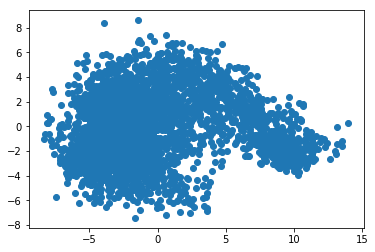

In [10]:
pca = PCA(32)
pred_t = pca.fit_transform(pred)
plt.scatter(pred_t[:,0], pred_t[:,2])

In [11]:
from sklearn.neighbors import KDTree

[[   0 3025  192 ..., 1796 2404 2270]
 [   1 1912 1285 ..., 2917 2072 1747]
 [   2 2054 2324 ...,  303 1679 1095]
 ..., 
 [3197 2280 2070 ...,  301 2621 2911]
 [3198 1808 3107 ..., 1764 1884  798]
 [3199 3011 2947 ..., 1167 2222  105]]


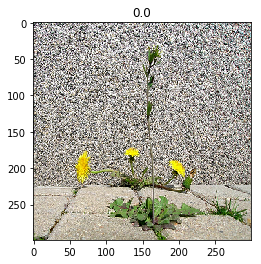

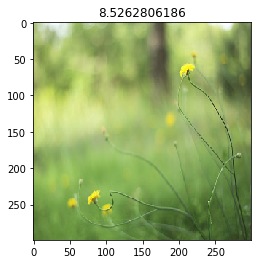

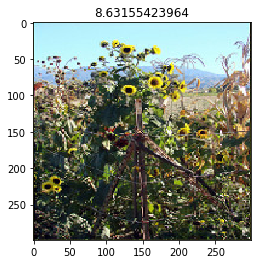

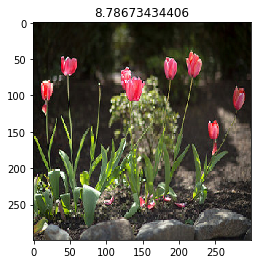

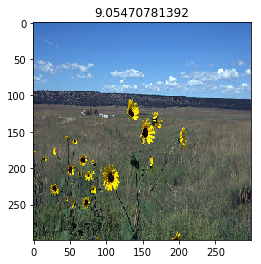

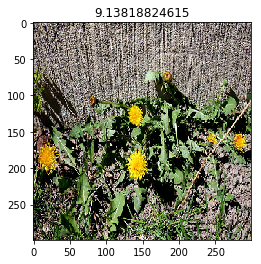

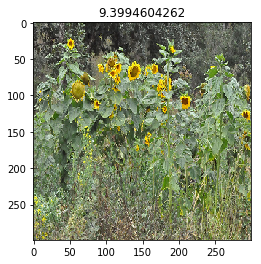

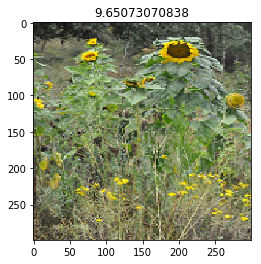

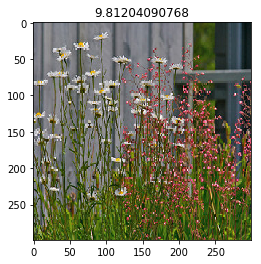

In [49]:
eval_pt = np.random.randint(0, len(pred_t))
tree = KDTree(pred_t, leaf_size=2)
dist, ix_arr = tree.query(pred_t, k=9)

print(ix_arr)

count = 0
for i, ix in enumerate(ix_arr[eval_pt]):
    count += 1
    img = X[ix]
    img = (img + 1)/2
    plt.figure()
    plt.imshow(img)
    plt.title(dist[eval_pt, i])
    if count > 10:
        break

In [ ]:
# km = KMeans(n_clusters=15)
# clusters = km.fit_predict(pred_t)

In [ ]:
# clus_contents = x[clusters == np.argmax(np.bincount(clusters))]

# for clus_id in range(0, np.max(clusters)):

#     clus_str = "=== CLUSTER {} ===".format(clus_id)
#     clus_contents = X[clusters == clus_id]

#     for img in clus_contents:
#         img = (img + 1)/2
#         plt.figure()
#         plt.title(clus_str)
#         plt.imshow(img)


In [ ]:
def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Args:
        base_model: keras model excluding top
        nb_classes: # of classes
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x) 
    predictions = Dense(nb_classes, activation='softmax')(x) 
    model = Model(input=base_model.input, output=predictions)
    return model

In [ ]:
model = add_new_last_layer(base_model, 5)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='rmsprop',    
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model_fitted = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
#    validation_data=validation_generator,
#    nb_val_samples=nb_val_samples,
    class_weight='auto',
    verbose=2)

In [ ]:
model_fitted.params

## Selective search

In [ ]:
x, y = train_generator.next()
img = (x[0] + 1) / 2.
img_lbl, regions = selectivesearch.selective_search(img, scale=100, sigma=0.9, min_size=512)

In [ ]:
plt.figure()
plt.imshow(img)
ax = plt.gca()

rects = [r['rect'] for r in regions]

for x, y, w, h in rects:
# #     print(x, y, w, h)     
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)


In [ ]:
r

## Test train generation 

In [ ]:
x, y = train_generator.next()
x = (x[0] + 1) / 2.

In [ ]:
plt.imshow(x)

In [ ]:
# for i, x in enumerate(train_datagen):
#     x
#     if i == 1:
#         break